# Installing Necessary Modules

In [1]:
!pip install transformers
!pip3 install datasets
!pip3 install py7zr
!pip3 install peft
!pip3 install evaluate
!pip install accelerate>=0.20.1

# Loading Dataset

In [2]:
from datasets import load_dataset

dataset = load_dataset("stanfordnlp/sst2")
dataset_train = dataset['train']
dataset_val = dataset['validation']
print(len(dataset_train))
print(len(dataset_val))

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


67349
872


# Fine Tuning BERT

## Load Model

In [3]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from peft import LoraConfig, get_peft_model
import torch

bert_tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")
bert_model = AutoModelForSequenceClassification.from_pretrained("google-bert/bert-base-uncased")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Tokenize data using Bert tokenizer

In [4]:
def tokenize_text(batch):
  return bert_tokenizer(batch["sentence"],padding="max_length", truncation=True)

In [5]:
dataset_train_tokenized = dataset_train.map(tokenize_text, batched=True, remove_columns=["idx"])
dataset_val_tokenized = dataset_val.map(tokenize_text, batched=True, remove_columns=["idx"])

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

In [6]:
import numpy as np
import evaluate

import torch
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = torch.argmax(torch.tensor(logits), dim=-1).numpy()
    # labels = labels.numpy()
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')
    acc = accuracy_score(labels, predictions)
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

In [7]:
batch_size = 32
num_epochs = 3
learning_rate = 1e-5

## Define Training Arguments

In [8]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="bert_sentiment_analysis",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    learning_rate=learning_rate,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    logging_steps=50,
    save_steps=1e6,
    gradient_accumulation_steps=16,
    load_best_model_at_end=True
)

## Fine-tune model

In [9]:
# Initialize Trainer
trainer = Trainer(
    model = bert_model,
    args = training_args,
    train_dataset = dataset_train_tokenized,
    eval_dataset = dataset_val_tokenized,
    compute_metrics = compute_metrics,
    tokenizer = bert_tokenizer
)

trainer.train()

<ipython-input-9-0a02ab279296>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: yashwanthsaipathipati (yashwanthsaipathipati-university-of-south-florida) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
0,0.311600,0.247344,0.900229,0.904762,0.898649,0.901695
1,0.209700,0.241963,0.901376,0.889130,0.921171,0.904867
2,0.192400,0.235869,0.905963,0.896930,0.921171,0.908889


TrainOutput(global_step=393, training_loss=0.26222944502308776, metrics={'train_runtime': 3807.3794, 'train_samples_per_second': 53.067, 'train_steps_per_second': 0.103, 'total_flos': 5.302634965303296e+16, 'train_loss': 0.26222944502308776, 'epoch': 2.9957244655581947})

## Evaluate and Save Model

In [10]:
results = trainer.evaluate()

In [11]:
bert_accuracy = results['eval_accuracy']
bert_precision = results['eval_precision']
bert_recall = results['eval_recall']
bert_f1 = results['eval_f1']

In [12]:
trainer.save_model("bert_sentiment_analysis")

# Fine Tuning DISTILBERT

## Load Model

In [13]:
distilbert_tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")
distilbert_model = AutoModelForSequenceClassification.from_pretrained("distilbert/distilbert-base-uncased")

lora_config = LoraConfig(
    r=8,
    lora_alpha=32,
    lora_dropout=0.1,
    task_type="SEQ_CLS",
    target_modules=["distilbert.transformer.layer.0.attention.q_lin",
                     "distilbert.transformer.layer.0.attention.k_lin",
                     "distilbert.transformer.layer.0.attention.v_lin",
                     "distilbert.transformer.layer.0.attention.out_lin",
                     "distilbert.transformer.layer.0.ffn.lin1",
                     "distilbert.transformer.layer.0.ffn.lin2",
                     "distilbert.transformer.layer.1.attention.q_lin",
                     "distilbert.transformer.layer.1.attention.k_lin",
                     "distilbert.transformer.layer.1.attention.v_lin",
                     "distilbert.transformer.layer.1.attention.out_lin",
                     "distilbert.transformer.layer.1.ffn.lin1",
                     "distilbert.transformer.layer.1.ffn.lin2",
                     "distilbert.transformer.layer.2.attention.q_lin",
                     "distilbert.transformer.layer.2.attention.k_lin",
                     "distilbert.transformer.layer.2.attention.v_lin",
                     "distilbert.transformer.layer.2.attention.out_lin",
                     "distilbert.transformer.layer.2.ffn.lin1",
                     "distilbert.transformer.layer.2.ffn.lin2",
                     "distilbert.transformer.layer.3.attention.q_lin",
                     "distilbert.transformer.layer.3.attention.k_lin",
                     "distilbert.transformer.layer.3.attention.v_lin",
                     "distilbert.transformer.layer.3.attention.out_lin",
                     "distilbert.transformer.layer.3.ffn.lin1",
                     "distilbert.transformer.layer.3.ffn.lin2",
                     "distilbert.transformer.layer.4.attention.q_lin",
                     "distilbert.transformer.layer.4.attention.k_lin",
                     "distilbert.transformer.layer.4.attention.v_lin",
                     "distilbert.transformer.layer.4.attention.out_lin",
                     "distilbert.transformer.layer.4.ffn.lin1",
                     "distilbert.transformer.layer.4.ffn.lin2",
                     "distilbert.transformer.layer.5.attention.q_lin",
                     "distilbert.transformer.layer.5.attention.k_lin",
                     "distilbert.transformer.layer.5.attention.v_lin",
                     "distilbert.transformer.layer.5.attention.out_lin",
                     "distilbert.transformer.layer.5.ffn.lin1",
                     "distilbert.transformer.layer.5.ffn.lin2"]
)

distilbert_model = get_peft_model(distilbert_model, lora_config)
distilbert_model.print_trainable_parameters()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 1,255,682 || all params: 68,210,692 || trainable%: 1.8409


## Tokenize data using DistilBERT tokenizer

In [14]:
def distilbert_tokenize_text(batch):
  return distilbert_tokenizer(batch["sentence"],padding="max_length", truncation=True)

In [15]:
dataset_train_tokenized = dataset_train.map(distilbert_tokenize_text, batched=True, remove_columns=["idx"])
dataset_val_tokenized = dataset_val.map(distilbert_tokenize_text, batched=True, remove_columns=["idx"])

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

## Define Training Arguments

In [16]:
training_args = TrainingArguments(
    output_dir="distilbert_sentiment_analysis",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    learning_rate=learning_rate,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    logging_steps=50,
    save_steps=1e6,
    gradient_accumulation_steps=16,
    load_best_model_at_end=True
)

## Fine-tune Model

In [17]:
# Initialize Trainer
trainer = Trainer(
    model = distilbert_model,
    args = training_args,
    train_dataset = dataset_train_tokenized,
    eval_dataset = dataset_val_tokenized,
    compute_metrics = compute_metrics,
    tokenizer = distilbert_tokenizer
)

trainer.train()

<ipython-input-17-e1542281a8df>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
0,0.645600,0.524526,0.816514,0.784000,0.882883,0.830508
1,0.356200,0.376966,0.826835,0.844706,0.808559,0.826237
2,0.345200,0.369490,0.829128,0.842227,0.817568,0.829714


TrainOutput(global_step=393, training_loss=0.45861285454747636, metrics={'train_runtime': 1681.9727, 'train_samples_per_second': 120.125, 'train_steps_per_second': 0.234, 'total_flos': 2.747436572737536e+16, 'train_loss': 0.45861285454747636, 'epoch': 2.9957244655581947})

## Evaluate and Save Model

In [18]:
results = trainer.evaluate()

In [19]:
distilbert_accuracy = results['eval_accuracy']
distilbert_precision = results['eval_precision']
distilbert_recall = results['eval_recall']
distilbert_f1 = results['eval_f1']

In [20]:
trainer.save_model("distilbert_sentiment_analysis")

# Knowledge Distillation from finetuned BERT to untrained distilBERT model

## Define DistillationTrainingArguments and DistillationTrainer Classes

In [21]:
from transformers import TrainingArguments

class DistillationTrainingArguments(TrainingArguments):
    def __init__(self, *args, alpha=0.5, temperature=2.0, **kwargs):
        super().__init__(*args, **kwargs)
        self.alpha = alpha
        self.temperature = temperature

In [22]:
import torch.nn as nn
import torch.nn.functional as F
from transformers import Trainer

class DistillationTrainer(Trainer):
    def __init__(self, *args, teacher_model=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.teacher_model = teacher_model

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        inputs = inputs.to(device)
        outputs_stu = model(**inputs)

        loss_ce = outputs_stu.loss
        logits_stu = outputs_stu.logits

        with torch.no_grad():
            outputs_tea = self.teacher_model(**inputs)
            logits_tea = outputs_tea.logits

        loss_fct = nn.KLDivLoss(reduction="batchmean")
        loss_kd = self.args.temperature ** 2 * loss_fct(
            F.log_softmax(logits_stu / self.args.temperature, dim=-1),
            F.softmax(logits_tea / self.args.temperature, dim=-1))

        loss = self.args.alpha * loss_ce + (1. - self.args.alpha) * loss_kd
        return (loss, outputs_stu) if return_outputs else loss

## Load Student Model

In [23]:
distilbert_kd_model = AutoModelForSequenceClassification.from_pretrained("distilbert/distilbert-base-uncased")

lora_config = LoraConfig(
    r=8,
    lora_alpha=32,
    lora_dropout=0.1,
    task_type="SEQ_CLS",
    target_modules=["distilbert.transformer.layer.0.attention.q_lin",
                     "distilbert.transformer.layer.0.attention.k_lin",
                     "distilbert.transformer.layer.0.attention.v_lin",
                     "distilbert.transformer.layer.0.attention.out_lin",
                     "distilbert.transformer.layer.0.ffn.lin1",
                     "distilbert.transformer.layer.0.ffn.lin2",
                     "distilbert.transformer.layer.1.attention.q_lin",
                     "distilbert.transformer.layer.1.attention.k_lin",
                     "distilbert.transformer.layer.1.attention.v_lin",
                     "distilbert.transformer.layer.1.attention.out_lin",
                     "distilbert.transformer.layer.1.ffn.lin1",
                     "distilbert.transformer.layer.1.ffn.lin2",
                     "distilbert.transformer.layer.2.attention.q_lin",
                     "distilbert.transformer.layer.2.attention.k_lin",
                     "distilbert.transformer.layer.2.attention.v_lin",
                     "distilbert.transformer.layer.2.attention.out_lin",
                     "distilbert.transformer.layer.2.ffn.lin1",
                     "distilbert.transformer.layer.2.ffn.lin2",
                     "distilbert.transformer.layer.3.attention.q_lin",
                     "distilbert.transformer.layer.3.attention.k_lin",
                     "distilbert.transformer.layer.3.attention.v_lin",
                     "distilbert.transformer.layer.3.attention.out_lin",
                     "distilbert.transformer.layer.3.ffn.lin1",
                     "distilbert.transformer.layer.3.ffn.lin2",
                     "distilbert.transformer.layer.4.attention.q_lin",
                     "distilbert.transformer.layer.4.attention.k_lin",
                     "distilbert.transformer.layer.4.attention.v_lin",
                     "distilbert.transformer.layer.4.attention.out_lin",
                     "distilbert.transformer.layer.4.ffn.lin1",
                     "distilbert.transformer.layer.4.ffn.lin2",
                     "distilbert.transformer.layer.5.attention.q_lin",
                     "distilbert.transformer.layer.5.attention.k_lin",
                     "distilbert.transformer.layer.5.attention.v_lin",
                     "distilbert.transformer.layer.5.attention.out_lin",
                     "distilbert.transformer.layer.5.ffn.lin1",
                     "distilbert.transformer.layer.5.ffn.lin2"]
)

distilbert_kd_model = get_peft_model(distilbert_kd_model, lora_config)
distilbert_kd_model.print_trainable_parameters()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 1,255,682 || all params: 68,210,692 || trainable%: 1.8409


In [24]:
batch_size = 48
num_epochs = 3
learning_rate = 2e-5

## Define Training Arguments

In [25]:
kd_training_args = DistillationTrainingArguments(
    output_dir="distilbert_kd_sentiment_analysis",
    per_device_train_batch_size=batch_size,
    weight_decay=0.01,
    eval_strategy = "epoch",
    learning_rate = learning_rate,
    gradient_accumulation_steps=4,
    num_train_epochs = num_epochs,
    logging_steps=500,
    save_steps=1000,
    eval_steps=1000,
    save_total_limit=2,
    fp16=True,
    report_to="none"
)

In [26]:
import torch
from transformers import AutoConfig

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def student_init():
    return (AutoModelForSequenceClassification
            .from_pretrained("distilbert-base-uncased", config=distilbert_kd_model.config).to(device))

## Perform KD

In [27]:
trainer = DistillationTrainer(model_init=student_init,
    teacher_model=bert_model, args=kd_training_args,
    train_dataset=dataset_train_tokenized, eval_dataset=dataset_val_tokenized,
    compute_metrics=compute_metrics, tokenizer=distilbert_tokenizer)

<ipython-input-22-a8c877baf46b>:7: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `DistillationTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [28]:
trainer.train()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.163795,0.901376,0.906818,0.898649,0.902715
2,0.201600,0.156292,0.908257,0.897380,0.925676,0.911308
3,0.100200,0.157921,0.902523,0.891068,0.921171,0.905869


TrainOutput(global_step=1053, training_loss=0.14785192042221257, metrics={'train_runtime': 1589.1933, 'train_samples_per_second': 127.138, 'train_steps_per_second': 0.663, 'total_flos': 2.676464049624883e+16, 'train_loss': 0.14785192042221257, 'epoch': 3.0})

## Evaluate and Save Model

In [29]:
results = trainer.evaluate()

In [30]:
distilbert_kd_accuracy = results['eval_accuracy']
distilbert_kd_precision = results['eval_precision']
distilbert_kd_recall = results['eval_recall']
distilbert_kd_f1 = results['eval_f1']

In [31]:
trainer.save_model("distilbert_kd_sentiment_analysis")

# Plot the Results

## Accuracy

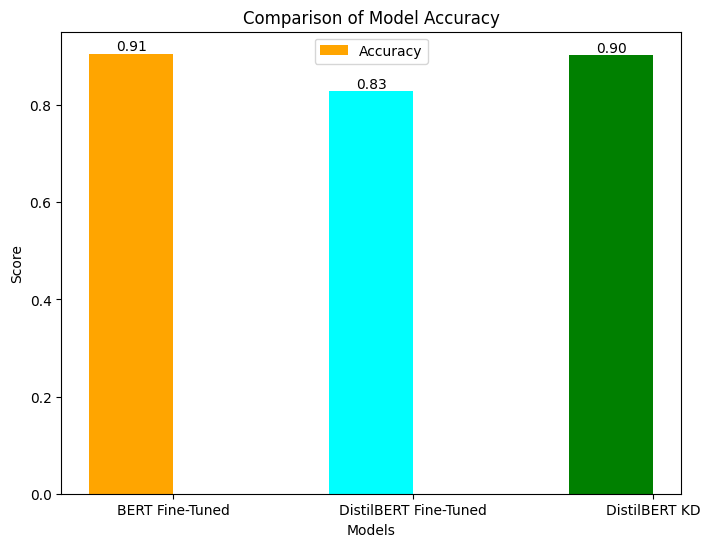

In [32]:
import numpy as np
import matplotlib.pyplot as plt

models = ["BERT Fine-Tuned", "DistilBERT Fine-Tuned", "DistilBERT KD"]
accuracy = [bert_accuracy, distilbert_accuracy, distilbert_kd_accuracy]
colors = ['orange', 'cyan', 'green']

x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 6))

bars = ax.bar(x - width/2, accuracy, width, label='Accuracy', color=colors)


for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height, f'{height:.2f}', ha='center', va='bottom')

ax.set_xlabel("Models")
ax.set_ylabel("Score")
ax.set_title("Comparison of Model Accuracy")
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

plt.show()

## F1-Score

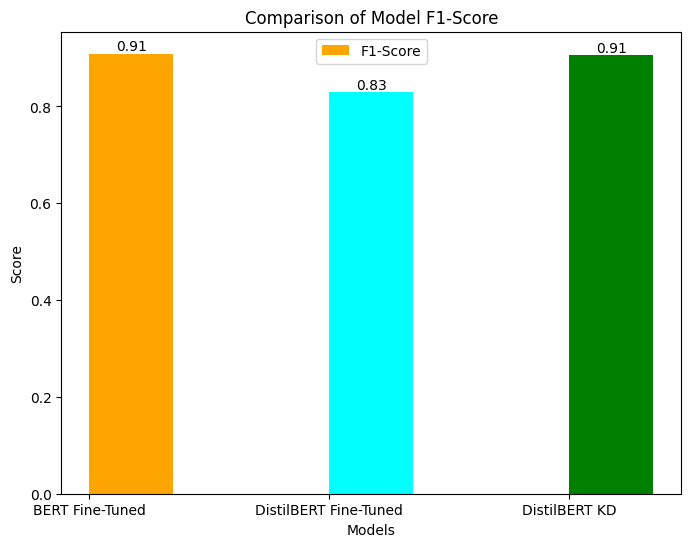

In [33]:
models = ["BERT Fine-Tuned", "DistilBERT Fine-Tuned", "DistilBERT KD"]
f1_score = [bert_f1, distilbert_f1, distilbert_kd_f1]
colors = ['orange', 'cyan', 'green']

x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 6))

bars = ax.bar(x + width/2, f1_score, width, label='F1-Score', color=colors)

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height, f'{height:.2f}', ha='center', va='bottom')

ax.set_xlabel("Models")
ax.set_ylabel("Score")
ax.set_title("Comparison of Model F1-Score")
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

plt.show()

## Precision

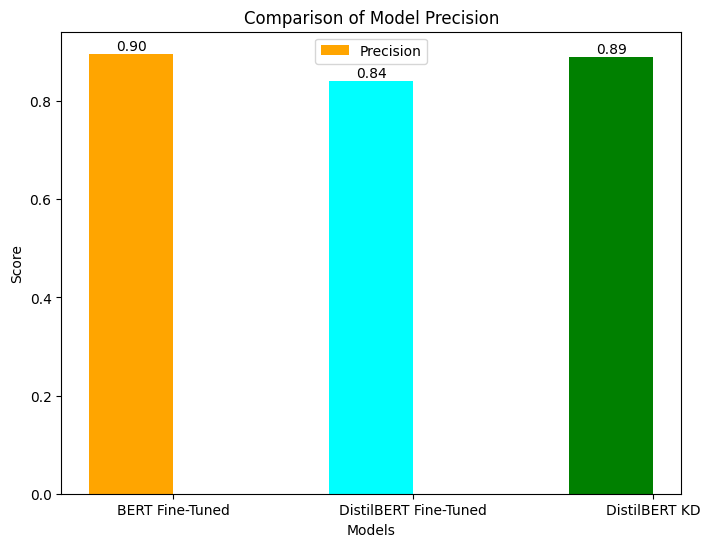

In [34]:
import numpy as np
import matplotlib.pyplot as plt

models = ["BERT Fine-Tuned", "DistilBERT Fine-Tuned", "DistilBERT KD"]
precision = [bert_precision, distilbert_precision, distilbert_kd_precision]
colors = ['orange', 'cyan', 'green']

x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 6))

bars = ax.bar(x - width/2, precision, width, label='Precision', color=colors)


for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height, f'{height:.2f}', ha='center', va='bottom')

ax.set_xlabel("Models")
ax.set_ylabel("Score")
ax.set_title("Comparison of Model Precision")
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

plt.show()

## Recall

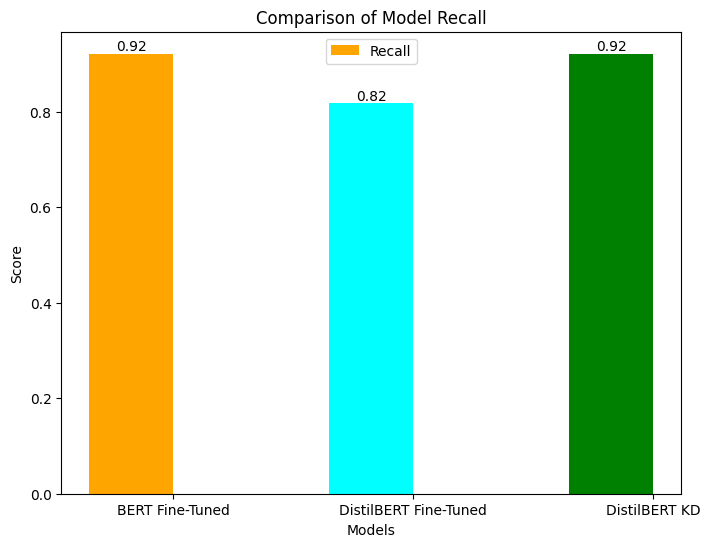

In [35]:
import numpy as np
import matplotlib.pyplot as plt

models = ["BERT Fine-Tuned", "DistilBERT Fine-Tuned", "DistilBERT KD"]
recall = [bert_recall, distilbert_recall, distilbert_kd_recall]
colors = ['orange', 'cyan', 'green']

x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 6))

bars = ax.bar(x - width/2, recall, width, label='Recall', color=colors)


for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height, f'{height:.2f}', ha='center', va='bottom')

ax.set_xlabel("Models")
ax.set_ylabel("Score")
ax.set_title("Comparison of Model Recall")
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

plt.show()

## Teacher-Student Model Parameters Comparision

In [36]:
from transformers import AutoModelForSequenceClassification
import os

def compute_parameters(model_path):
  model = AutoModelForSequenceClassification.from_pretrained(model_path)
  parameters = model.num_parameters()
  return parameters

In [37]:
bert_model_parameters = compute_parameters(model_path="/content/bert_sentiment_analysis")
bert_model_parameters

109483778

In [38]:
distilbert_model_parameters = compute_parameters(model_path="/content/distilbert_sentiment_analysis")
distilbert_model_parameters

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


68210692

In [39]:
distilbert_model_kd_parameters = compute_parameters(model_path="/content/distilbert_kd_sentiment_analysis")
distilbert_model_kd_parameters

66955010

In [40]:
decrease = (bert_model_parameters-distilbert_model_kd_parameters)/bert_model_parameters
print(decrease*100)

38.84481224241275


## Teacher-Student Model Size Comaprision

In [41]:
!ls /content/bert_sentiment_analysis -al --block-size=MB

total 439MB
drwxr-xr-x 5 root root   1MB Mar 10 00:01 .
drwxr-xr-x 1 root root   1MB Mar 10 00:01 ..
drwxr-xr-x 2 root root   1MB Mar  9 22:10 checkpoint-131
drwxr-xr-x 2 root root   1MB Mar  9 23:40 checkpoint-262
drwxr-xr-x 2 root root   1MB Mar 10 00:01 checkpoint-393
-rw-r--r-- 1 root root   1MB Mar 10 00:01 config.json
-rw-r--r-- 1 root root 438MB Mar 10 00:01 model.safetensors
-rw-r--r-- 1 root root   1MB Mar 10 00:01 special_tokens_map.json
-rw-r--r-- 1 root root   1MB Mar 10 00:01 tokenizer_config.json
-rw-r--r-- 1 root root   1MB Mar 10 00:01 tokenizer.json
-rw-r--r-- 1 root root   1MB Mar 10 00:01 training_args.bin
-rw-r--r-- 1 root root   1MB Mar 10 00:01 vocab.txt


In [43]:
!ls /content/distilbert_kd_sentiment_analysis -al --block-size=MB

total 269MB
drwxr-xr-x 4 root root   1MB Mar 10 00:56 .
drwxr-xr-x 1 root root   1MB Mar 10 00:01 ..
drwxr-xr-x 2 root root   1MB Mar 10 00:54 checkpoint-1000
drwxr-xr-x 2 root root   1MB Mar 10 00:56 checkpoint-1053
-rw-r--r-- 1 root root   1MB Mar 10 00:56 config.json
-rw-r--r-- 1 root root 268MB Mar 10 00:56 model.safetensors
-rw-r--r-- 1 root root   1MB Mar 10 00:56 special_tokens_map.json
-rw-r--r-- 1 root root   1MB Mar 10 00:56 tokenizer_config.json
-rw-r--r-- 1 root root   1MB Mar 10 00:56 tokenizer.json
-rw-r--r-- 1 root root   1MB Mar 10 00:56 training_args.bin
-rw-r--r-- 1 root root   1MB Mar 10 00:56 vocab.txt


## Teacher-Student Inference Time Comparision

In [44]:
from transformers import pipeline
import time

pipe = pipeline("text-classification", model="/content/bert_sentiment_analysis", tokenizer='bert-base-uncased', device='cpu')

sample_input = dataset['train']['sentence'][101]

for _ in range(10):
  _ = pipe(sample_input)

start = time.time()
for _ in range(100):
  _ = pipe(sample_input)
total_time_bert_model = time.time()-start
print("Total time to process 100 requests for BERT Model: ",total_time_bert_model)

Device set to use cpu


Total time to process 100 requests for BERT Model:  1.9644031524658203


In [45]:
from transformers import pipeline
import time

pipe = pipeline("text-classification", model="/content/distilbert_kd_sentiment_analysis", tokenizer='distilbert-base-uncased', device='cpu')

sample_input = dataset['train']['sentence'][101]

for _ in range(10):
  _ = pipe(sample_input)

start = time.time()
for _ in range(100):
  _ = pipe(sample_input)
total_time_distilbert_kd_model = time.time()-start
print("Total time to process 100 requests for DISTILBERT KD Model: ",total_time_distilbert_kd_model)

Device set to use cpu


Total time to process 100 requests for DISTILBERT KD Model:  1.0097944736480713


In [46]:
decrease_in_time = (total_time_bert_model-total_time_distilbert_kd_model)/total_time_bert_model
print(decrease_in_time*100)

48.59535465616999
